In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                    labels=tf.zeros_like(gQs_notequal))) # 0-1
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                    labels=rates_equal)) # 0-1
    targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
    glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    return actions_logits, gQs, gloss, dloss, glossQ, dlossQ, gQs_notequal, gQs_equal

In [7]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_lossQ, self.d_lossQ, self.gQs_notequal, self.gQs_equal = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, 
                                           d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

/home/arasdar/miniconda3/envs/env/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch, glossQ_batch, dlossQ_batch= [], [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _, glossQ, dlossQ = sess.run([model.d_loss, model.d_opt, 
                                                 model.g_lossQ, model.d_lossQ],
                                                feed_dict = {model.states: states, 
                                                             model.actions: actions,
                                                             model.targetQs: targetQs, 
                                                             model.rates: rates})
            gloss, _, gQs_notequal, gQs_equal = sess.run([model.g_loss, model.g_opt, 
                                                          model.gQs_notequal, model.gQs_equal], 
                                              feed_dict = {model.states: states, 
                                                           model.actions: actions,
                                                           model.targetQs: targetQs, 
                                                           model.rates: rates})
            #if len(gQs_nonequal) != len(nextQs):
            # if dloss is np.nan:            
            #     print(gQs_notequal.shape, gQs_notequal.dtype)
            #     print(gQs_equal.shape, gQs_equal.dtype)
            #     print(nextQs.shape)
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            glossQ_batch.append(glossQ)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'glossQ:{:.4f}'.format(np.mean(glossQ_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:21.0000 R:21.0000 rate:0.0420 gloss:1.3905 dloss:3.5979 glossQ:1.0007 dlossQ:0.3822 exploreP:0.9979
Episode:1 meanR:18.0000 R:15.0000 rate:0.0300 gloss:1.3873 dloss:3.5859 glossQ:1.0010 dlossQ:0.3701 exploreP:0.9964
Episode:2 meanR:17.6667 R:17.0000 rate:0.0340 gloss:1.3872 dloss:3.5732 glossQ:1.0011 dlossQ:0.3904 exploreP:0.9948
Episode:3 meanR:18.2500 R:20.0000 rate:0.0400 gloss:1.3848 dloss:3.5639 glossQ:1.0019 dlossQ:0.3810 exploreP:0.9928
Episode:4 meanR:17.4000 R:14.0000 rate:0.0280 gloss:1.3819 dloss:3.5513 glossQ:1.0027 dlossQ:0.3788 exploreP:0.9914
Episode:5 meanR:20.3333 R:35.0000 rate:0.0700 gloss:1.3798 dloss:3.5329 glossQ:1.0032 dlossQ:0.3888 exploreP:0.9880
Episode:6 meanR:20.4286 R:21.0000 rate:0.0420 gloss:1.3764 dloss:3.5166 glossQ:1.0039 dlossQ:0.3904 exploreP:0.9859
Episode:7 meanR:19.2500 R:11.0000 rate:0.0220 gloss:1.3767 dloss:3.5042 glossQ:1.0042 dlossQ:0.4070 exploreP:0.9849
Episode:8 meanR:18.6667 R:14.0000 rate:0.0280 gloss:1.3741 dloss:3.4955 

Episode:71 meanR:23.2083 R:36.0000 rate:0.0720 gloss:1.2734 dloss:2.8840 glossQ:1.0710 dlossQ:0.7761 exploreP:0.8477
Episode:72 meanR:23.0548 R:12.0000 rate:0.0240 gloss:1.2918 dloss:2.9198 glossQ:1.0674 dlossQ:0.7804 exploreP:0.8466
Episode:73 meanR:23.1081 R:27.0000 rate:0.0540 gloss:1.2692 dloss:2.8703 glossQ:1.0703 dlossQ:0.8002 exploreP:0.8444
Episode:74 meanR:23.3333 R:40.0000 rate:0.0800 gloss:1.2754 dloss:2.8769 glossQ:1.0831 dlossQ:0.8345 exploreP:0.8411
Episode:75 meanR:23.3684 R:26.0000 rate:0.0520 gloss:1.2647 dloss:2.8594 glossQ:1.0901 dlossQ:0.8578 exploreP:0.8389
Episode:76 meanR:23.3117 R:19.0000 rate:0.0380 gloss:1.2922 dloss:2.9142 glossQ:1.0669 dlossQ:0.8765 exploreP:0.8373
Episode:77 meanR:23.4359 R:33.0000 rate:0.0660 gloss:1.2594 dloss:2.8402 glossQ:1.0743 dlossQ:0.8597 exploreP:0.8346
Episode:78 meanR:23.4937 R:28.0000 rate:0.0560 gloss:1.2645 dloss:2.8491 glossQ:1.0703 dlossQ:0.8576 exploreP:0.8323
Episode:79 meanR:23.3750 R:14.0000 rate:0.0280 gloss:1.2727 dlos

Episode:141 meanR:21.8400 R:11.0000 rate:0.0220 gloss:1.2182 dloss:2.6908 glossQ:1.1078 dlossQ:1.1128 exploreP:0.7346
Episode:142 meanR:21.7100 R:10.0000 rate:0.0200 gloss:1.2100 dloss:2.6721 glossQ:1.1038 dlossQ:1.0940 exploreP:0.7339
Episode:143 meanR:21.8500 R:33.0000 rate:0.0660 gloss:1.2184 dloss:2.6849 glossQ:1.1021 dlossQ:1.0620 exploreP:0.7315
Episode:144 meanR:22.3300 R:73.0000 rate:0.1460 gloss:1.2163 dloss:2.6741 glossQ:1.1056 dlossQ:1.0340 exploreP:0.7262
Episode:145 meanR:22.3700 R:14.0000 rate:0.0280 gloss:1.2122 dloss:2.6570 glossQ:1.1054 dlossQ:0.9822 exploreP:0.7252
Episode:146 meanR:22.5000 R:27.0000 rate:0.0540 gloss:1.2206 dloss:2.6774 glossQ:1.0964 dlossQ:0.9710 exploreP:0.7233
Episode:147 meanR:22.2100 R:19.0000 rate:0.0380 gloss:1.2070 dloss:2.6482 glossQ:1.1042 dlossQ:0.9639 exploreP:0.7219
Episode:148 meanR:22.1900 R:13.0000 rate:0.0260 gloss:1.2190 dloss:2.6630 glossQ:1.1049 dlossQ:0.9641 exploreP:0.7210
Episode:149 meanR:22.1200 R:17.0000 rate:0.0340 gloss:1.

Episode:211 meanR:17.7500 R:11.0000 rate:0.0220 gloss:1.2194 dloss:2.7005 glossQ:1.0989 dlossQ:1.0357 exploreP:0.6521
Episode:212 meanR:17.8300 R:19.0000 rate:0.0380 gloss:1.2175 dloss:2.7037 glossQ:1.0926 dlossQ:1.0516 exploreP:0.6509
Episode:213 meanR:17.6700 R:12.0000 rate:0.0240 gloss:1.2314 dloss:2.7281 glossQ:1.0908 dlossQ:1.0301 exploreP:0.6501
Episode:214 meanR:17.6300 R:14.0000 rate:0.0280 gloss:1.2153 dloss:2.6979 glossQ:1.0990 dlossQ:1.0357 exploreP:0.6492
Episode:215 meanR:17.5500 R:9.0000 rate:0.0180 gloss:1.2283 dloss:2.7214 glossQ:1.0959 dlossQ:1.0392 exploreP:0.6486
Episode:216 meanR:17.5900 R:14.0000 rate:0.0280 gloss:1.2230 dloss:2.7138 glossQ:1.0925 dlossQ:1.0313 exploreP:0.6477
Episode:217 meanR:17.5500 R:10.0000 rate:0.0200 gloss:1.2173 dloss:2.7041 glossQ:1.0978 dlossQ:1.0252 exploreP:0.6471
Episode:218 meanR:17.6000 R:17.0000 rate:0.0340 gloss:1.2075 dloss:2.6785 glossQ:1.1042 dlossQ:1.0560 exploreP:0.6460
Episode:219 meanR:17.2800 R:11.0000 rate:0.0220 gloss:1.2

Episode:281 meanR:13.9100 R:14.0000 rate:0.0280 gloss:1.2130 dloss:2.6800 glossQ:1.1002 dlossQ:0.8930 exploreP:0.5934
Episode:282 meanR:13.9000 R:10.0000 rate:0.0200 gloss:1.2159 dloss:2.6850 glossQ:1.0986 dlossQ:0.8892 exploreP:0.5928
Episode:283 meanR:13.8700 R:10.0000 rate:0.0200 gloss:1.2371 dloss:2.7275 glossQ:1.0964 dlossQ:0.8586 exploreP:0.5923
Episode:284 meanR:13.9300 R:16.0000 rate:0.0320 gloss:1.2336 dloss:2.7120 glossQ:1.0911 dlossQ:0.8709 exploreP:0.5913
Episode:285 meanR:13.9800 R:16.0000 rate:0.0320 gloss:1.2138 dloss:2.6763 glossQ:1.1012 dlossQ:0.8792 exploreP:0.5904
Episode:286 meanR:13.8500 R:10.0000 rate:0.0200 gloss:1.2130 dloss:2.6690 glossQ:1.1217 dlossQ:0.8725 exploreP:0.5898
Episode:287 meanR:13.8700 R:13.0000 rate:0.0260 gloss:1.2273 dloss:2.7047 glossQ:1.0953 dlossQ:0.8615 exploreP:0.5891
Episode:288 meanR:13.8700 R:8.0000 rate:0.0160 gloss:1.1967 dloss:2.6417 glossQ:1.1090 dlossQ:0.8730 exploreP:0.5886
Episode:289 meanR:13.8500 R:11.0000 rate:0.0220 gloss:1.2

Episode:351 meanR:13.3400 R:14.0000 rate:0.0280 gloss:1.2164 dloss:2.6661 glossQ:1.0994 dlossQ:0.8155 exploreP:0.5407
Episode:352 meanR:13.3200 R:12.0000 rate:0.0240 gloss:1.2089 dloss:2.6439 glossQ:1.0879 dlossQ:0.7842 exploreP:0.5400
Episode:353 meanR:13.3500 R:14.0000 rate:0.0280 gloss:1.2047 dloss:2.6350 glossQ:1.1144 dlossQ:0.8463 exploreP:0.5393
Episode:354 meanR:13.3900 R:16.0000 rate:0.0320 gloss:1.2145 dloss:2.6538 glossQ:1.0996 dlossQ:0.8589 exploreP:0.5384
Episode:355 meanR:13.3800 R:10.0000 rate:0.0200 gloss:1.2080 dloss:2.6427 glossQ:1.1040 dlossQ:0.7991 exploreP:0.5379
Episode:356 meanR:13.4600 R:20.0000 rate:0.0400 gloss:1.2117 dloss:2.6532 glossQ:1.0924 dlossQ:0.8119 exploreP:0.5368
Episode:357 meanR:13.4900 R:15.0000 rate:0.0300 gloss:1.2107 dloss:2.6508 glossQ:1.1150 dlossQ:0.8792 exploreP:0.5361
Episode:358 meanR:13.5100 R:12.0000 rate:0.0240 gloss:1.2226 dloss:2.6668 glossQ:1.0953 dlossQ:0.7972 exploreP:0.5354
Episode:359 meanR:13.5300 R:16.0000 rate:0.0320 gloss:1.

Episode:421 meanR:14.4900 R:15.0000 rate:0.0300 gloss:1.1636 dloss:2.4780 glossQ:1.1331 dlossQ:0.6614 exploreP:0.4902
Episode:422 meanR:14.4700 R:13.0000 rate:0.0260 gloss:1.1766 dloss:2.4994 glossQ:1.1184 dlossQ:0.6518 exploreP:0.4896
Episode:423 meanR:14.4500 R:11.0000 rate:0.0220 gloss:1.1768 dloss:2.5059 glossQ:1.1579 dlossQ:0.6850 exploreP:0.4890
Episode:424 meanR:14.4400 R:16.0000 rate:0.0320 gloss:1.1717 dloss:2.4740 glossQ:1.1860 dlossQ:0.7196 exploreP:0.4883
Episode:425 meanR:14.4500 R:10.0000 rate:0.0200 gloss:1.2068 dloss:2.4964 glossQ:1.4093 dlossQ:0.8425 exploreP:0.4878
Episode:426 meanR:14.3800 R:14.0000 rate:0.0280 gloss:1.1784 dloss:2.5123 glossQ:1.1274 dlossQ:0.6735 exploreP:0.4871
Episode:427 meanR:14.4500 R:16.0000 rate:0.0320 gloss:1.1399 dloss:2.4356 glossQ:1.1493 dlossQ:0.6774 exploreP:0.4864
Episode:428 meanR:14.4100 R:9.0000 rate:0.0180 gloss:1.1608 dloss:2.4782 glossQ:1.1195 dlossQ:0.6560 exploreP:0.4859
Episode:429 meanR:14.2900 R:13.0000 rate:0.0260 gloss:1.1

Episode:491 meanR:21.7000 R:22.0000 rate:0.0440 gloss:1.2266 dloss:2.7004 glossQ:1.1434 dlossQ:1.2335 exploreP:0.4128
Episode:492 meanR:21.8400 R:33.0000 rate:0.0660 gloss:1.2270 dloss:2.7038 glossQ:1.1230 dlossQ:1.1847 exploreP:0.4115
Episode:493 meanR:22.0100 R:30.0000 rate:0.0600 gloss:1.2233 dloss:2.6909 glossQ:1.1151 dlossQ:1.1412 exploreP:0.4103
Episode:494 meanR:22.1900 R:30.0000 rate:0.0600 gloss:1.2200 dloss:2.6825 glossQ:1.1433 dlossQ:1.1643 exploreP:0.4091
Episode:495 meanR:22.4600 R:37.0000 rate:0.0740 gloss:1.2426 dloss:2.7250 glossQ:1.1106 dlossQ:1.0965 exploreP:0.4076
Episode:496 meanR:22.6900 R:33.0000 rate:0.0660 gloss:1.2274 dloss:2.7054 glossQ:1.1231 dlossQ:1.1327 exploreP:0.4063
Episode:497 meanR:22.7800 R:20.0000 rate:0.0400 gloss:1.2191 dloss:2.6852 glossQ:1.1250 dlossQ:1.1198 exploreP:0.4055
Episode:498 meanR:23.0200 R:36.0000 rate:0.0720 gloss:1.2236 dloss:2.6923 glossQ:1.1107 dlossQ:1.0853 exploreP:0.4041
Episode:499 meanR:23.4800 R:58.0000 rate:0.1160 gloss:1.

Episode:561 meanR:58.3100 R:61.0000 rate:0.1220 gloss:1.2338 dloss:2.7101 glossQ:1.1119 dlossQ:0.9780 exploreP:0.2632
Episode:562 meanR:58.9600 R:83.0000 rate:0.1660 gloss:1.2214 dloss:2.6879 glossQ:1.1064 dlossQ:0.9727 exploreP:0.2611
Episode:563 meanR:59.1600 R:34.0000 rate:0.0680 gloss:1.2395 dloss:2.7201 glossQ:1.0967 dlossQ:0.9616 exploreP:0.2602
Episode:564 meanR:59.7800 R:77.0000 rate:0.1540 gloss:1.2389 dloss:nan glossQ:1.1439 dlossQ:1.0130 exploreP:0.2583
Episode:565 meanR:60.3200 R:69.0000 rate:0.1380 gloss:1.2218 dloss:2.6894 glossQ:1.1056 dlossQ:0.9659 exploreP:0.2566
Episode:566 meanR:61.2300 R:117.0000 rate:0.2340 gloss:1.2293 dloss:2.7013 glossQ:1.1026 dlossQ:0.9603 exploreP:0.2537
Episode:567 meanR:61.7400 R:78.0000 rate:0.1560 gloss:1.2235 dloss:nan glossQ:1.1029 dlossQ:0.9684 exploreP:0.2518
Episode:568 meanR:62.4100 R:91.0000 rate:0.1820 gloss:1.2280 dloss:2.6995 glossQ:1.1004 dlossQ:0.9623 exploreP:0.2497
Episode:569 meanR:62.8200 R:62.0000 rate:0.1240 gloss:1.2244 

Episode:631 meanR:81.8800 R:70.0000 rate:0.1400 gloss:1.2594 dloss:2.7997 glossQ:1.1023 dlossQ:1.0190 exploreP:0.1497
Episode:632 meanR:83.1100 R:171.0000 rate:0.3420 gloss:1.2673 dloss:nan glossQ:1.1144 dlossQ:1.0240 exploreP:0.1473
Episode:633 meanR:83.1900 R:78.0000 rate:0.1560 gloss:1.2722 dloss:nan glossQ:1.0837 dlossQ:0.9892 exploreP:0.1463
Episode:634 meanR:83.2800 R:100.0000 rate:0.2000 gloss:1.2769 dloss:2.8305 glossQ:1.0820 dlossQ:0.9848 exploreP:0.1449
Episode:635 meanR:82.7200 R:58.0000 rate:0.1160 gloss:1.2709 dloss:2.8252 glossQ:1.1054 dlossQ:1.0079 exploreP:0.1441
Episode:636 meanR:84.0200 R:182.0000 rate:0.3640 gloss:1.2724 dloss:nan glossQ:1.1244 dlossQ:1.0291 exploreP:0.1417
Episode:637 meanR:83.9200 R:46.0000 rate:0.0920 gloss:1.2485 dloss:nan glossQ:1.0895 dlossQ:0.9964 exploreP:0.1411
Episode:638 meanR:84.5200 R:118.0000 rate:0.2360 gloss:1.2718 dloss:2.8203 glossQ:1.0837 dlossQ:0.9856 exploreP:0.1396
Episode:639 meanR:84.7500 R:84.0000 rate:0.1680 gloss:1.2812 dlo

Episode:701 meanR:87.8100 R:63.0000 rate:0.1260 gloss:1.2866 dloss:2.8608 glossQ:1.0837 dlossQ:0.9745 exploreP:0.0841
Episode:702 meanR:89.0900 R:186.0000 rate:0.3720 gloss:1.2771 dloss:2.8433 glossQ:1.0839 dlossQ:0.9775 exploreP:0.0827
Episode:703 meanR:88.6900 R:93.0000 rate:0.1860 gloss:1.2795 dloss:2.8429 glossQ:1.0899 dlossQ:0.9855 exploreP:0.0820
Episode:704 meanR:89.4500 R:181.0000 rate:0.3620 gloss:1.2842 dloss:nan glossQ:1.0842 dlossQ:0.9774 exploreP:0.0807
Episode:705 meanR:89.1800 R:56.0000 rate:0.1120 gloss:1.2864 dloss:nan glossQ:1.1165 dlossQ:0.9819 exploreP:0.0804
Episode:706 meanR:89.8400 R:115.0000 rate:0.2300 gloss:1.2989 dloss:2.8884 glossQ:1.0860 dlossQ:0.9746 exploreP:0.0795
Episode:707 meanR:89.7500 R:59.0000 rate:0.1180 gloss:1.2744 dloss:2.8431 glossQ:1.0803 dlossQ:0.9695 exploreP:0.0791
Episode:708 meanR:90.7600 R:157.0000 rate:0.3140 gloss:1.2889 dloss:2.8733 glossQ:1.0843 dlossQ:0.9832 exploreP:0.0781
Episode:709 meanR:92.2300 R:212.0000 rate:0.4240 gloss:1.2

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

In [ ]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

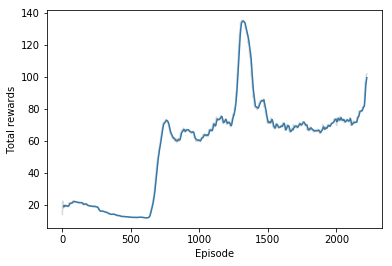

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

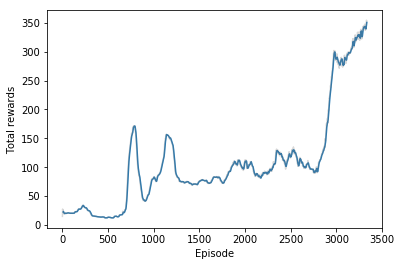

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

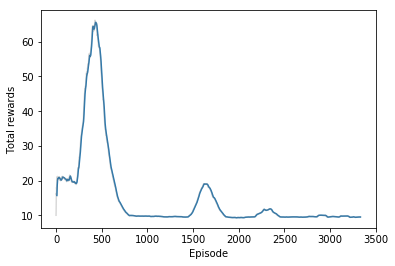

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

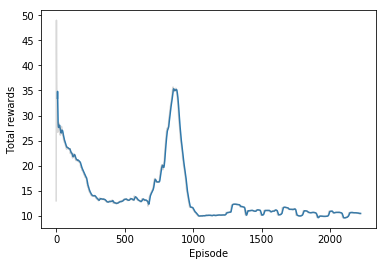

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

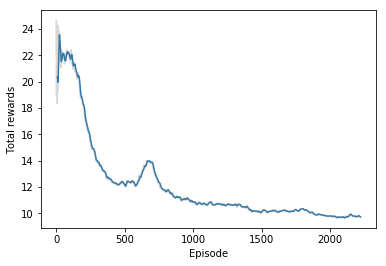

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

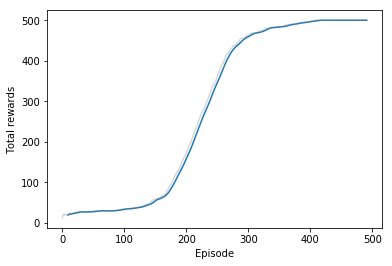

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

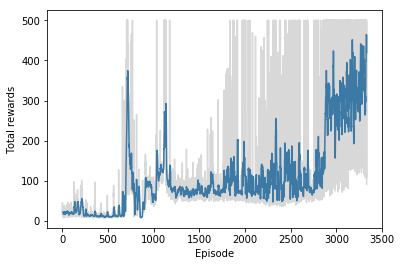

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

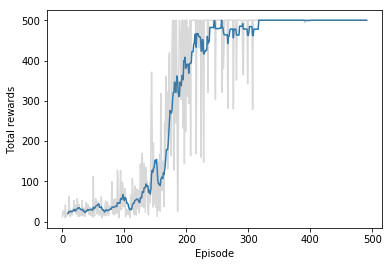

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.